In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2],
    "verbose": False,
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5
}

sm_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
    }
}


[Trial 0]
At least one slice was clobbered. Trying again.
At least one slice was clobbered. Trying again.
---------- Training DP ----------
---------- Training SM ----------
[Trial 1]
---------- Training DP ----------
---------- Training SM ----------
[Trial 2]
---------- Training DP ----------
---------- Training SM ----------
[Trial 3]
---------- Training DP ----------
---------- Training SM ----------
[Trial 4]
---------- Training DP ----------
---------- Training SM ----------
[Trial 5]
---------- Training DP ----------
---------- Training SM ----------
[Trial 6]
---------- Training DP ----------
---------- Training SM ----------
[Trial 7]
---------- Training DP ----------
---------- Training SM ----------
[Trial 8]
---------- Training DP ----------
---------- Training SM ----------
[Trial 9]
---------- Training DP ----------
---------- Training SM ----------
[Trial 10]
---------- Training DP ----------
---------- Training SM ----------
[Trial 11]
At least one slice was clobbered. 

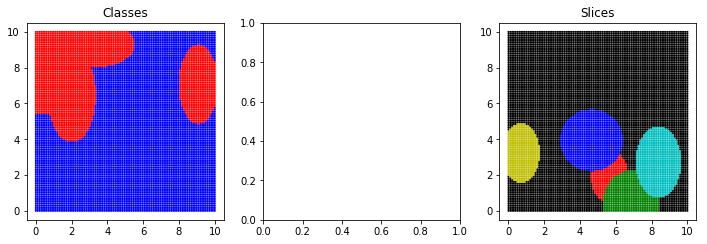

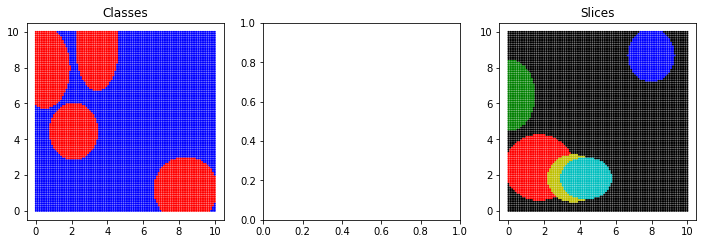

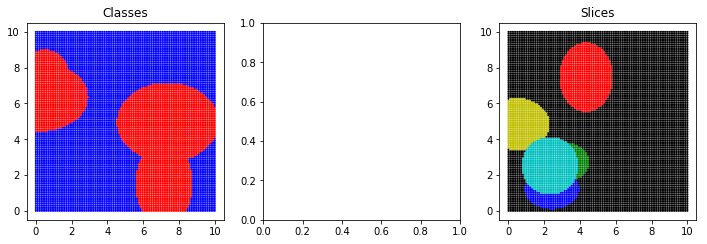

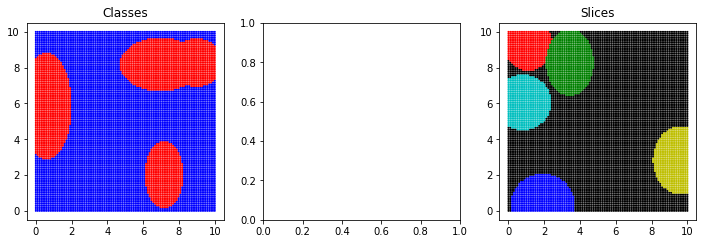

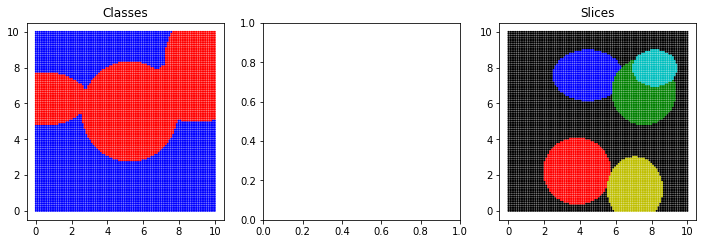

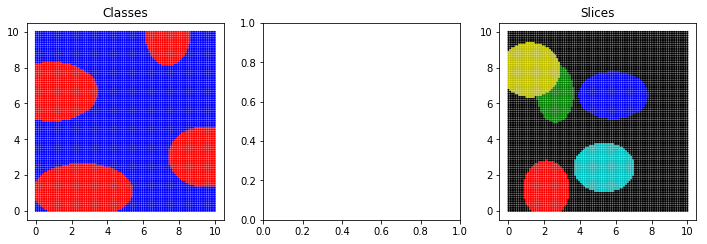

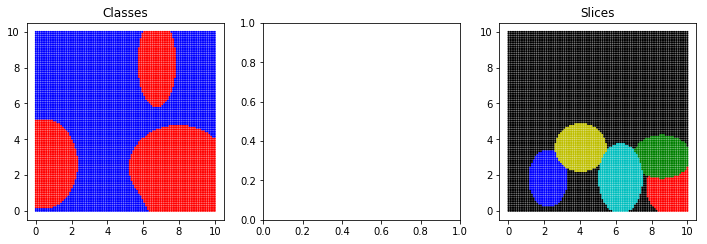

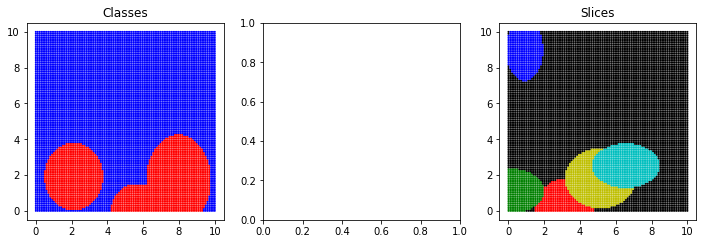

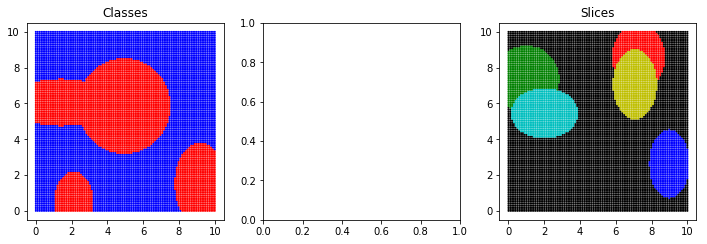

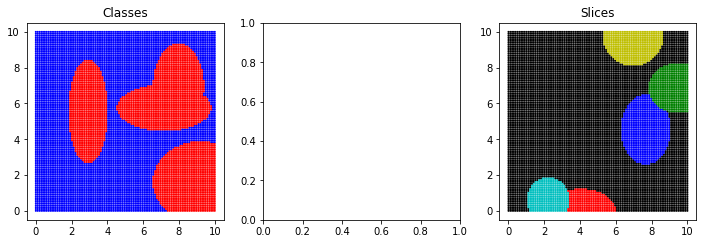

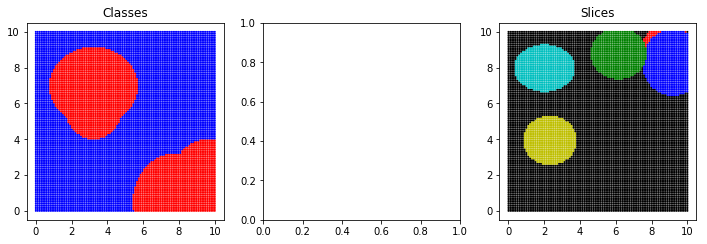

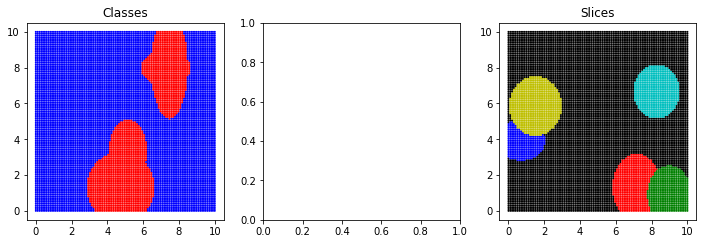

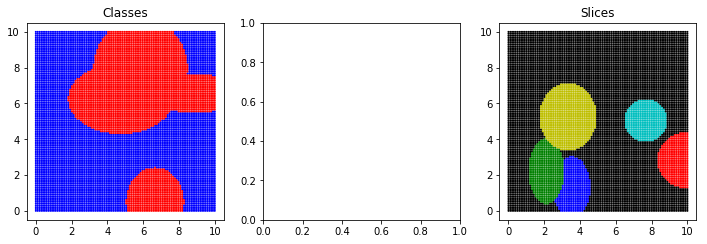

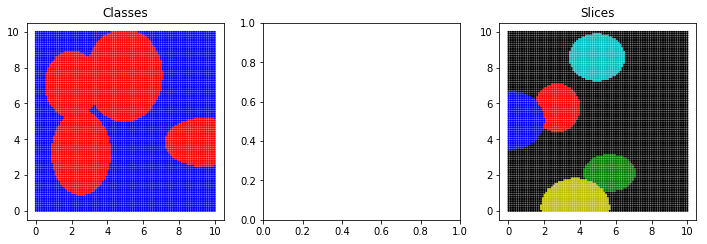

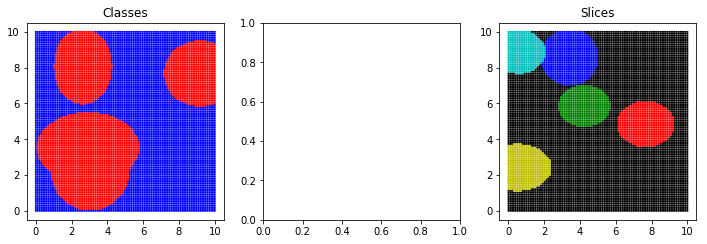

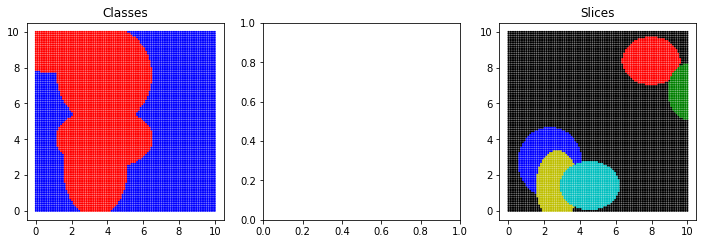

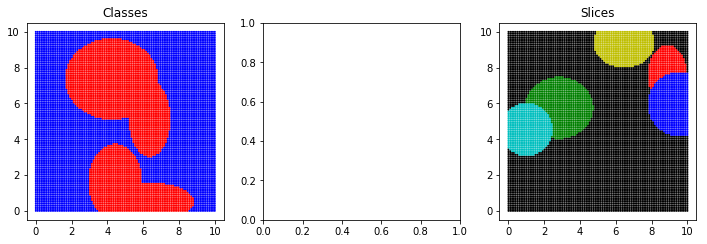

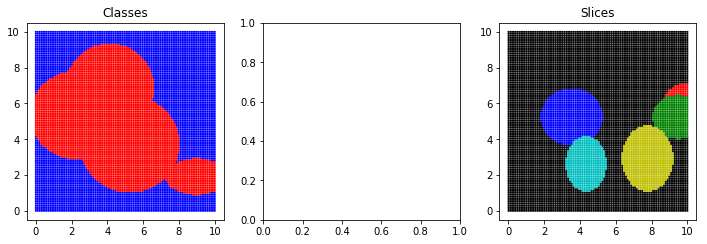

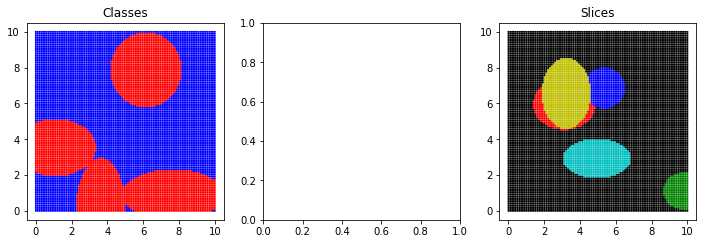

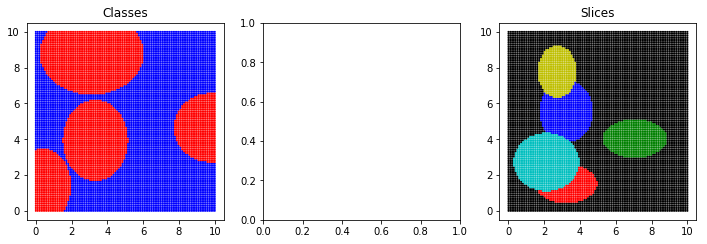

In [3]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UPx2": up_config,
#     "MoE": moe_config,
    "DP": dp_config,
    "SM": sm_config,
}

NUM_TRIALS = 20
NUM_SLICES = 5
K = 2
M = 20
N = 5000
salt = 43  # A base to add to trial number to set a unique seed for each trial


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    Z_kwargs = {'num_slices': NUM_SLICES}
    L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                     Z_kwargs=Z_kwargs,
                                                     return_targeting_lfs=True,
                                                     seed=(salt + trial))

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        # Generate weak labels:
        if model_name == "UNI" or model_name.startswith("UP"):
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train

        # Train end model
        
        if model_name == "UNI":
            L_weights = list(np.ones(M))
            model = train_model(model_config, Ls, Xs, Ys, Zs, L_weights)
        elif model_name.startswith('UP'):
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM":
            model = train_model(model_config, Ls, Xs, Ys, Zs)        
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")

        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

In [4]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=20):


,DP,SM
all,0.849840,0.849820
slice_1,0.944679,0.921870
slice_2,0.859431,0.917765
slice_3,0.871241,0.911161
slice_4,0.881866,0.878835
slice_5,0.840881,0.860513
slice_avg,0.879620,0.898029


## Grid Search

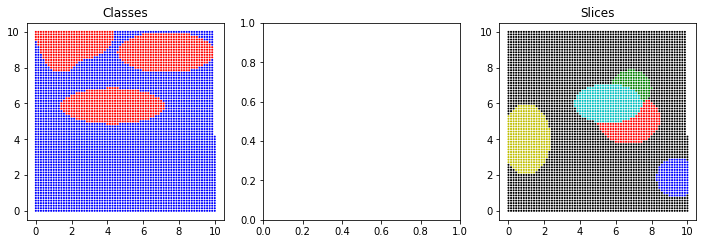

In [56]:
NUM_TRIALS = 20
NUM_SLICES = 5
K = 2
M = 20
N = 5000
salt = 42  # A base to add to trial number to set a unique seed for each trial

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                 Z_kwargs=Z_kwargs,
                                                 return_targeting_lfs=True,
                                                 seed=(salt + trial))

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])
Y_train = label_model.predict_proba(Ls[0])
Ys[0] = Y_train

In [57]:
layer_out_dims = [2, 10, 10, 2]
search_space = {
    'n_epochs': [10, 20, 40],
    'lr': {'range': [0.001, 1], 'scale': 'log'} ,
    'l2': 0, #{'range': [0.0001, 10], 'scale': 'log'},
    'slice_weight': [0.01, 0.05, 0.1, 0.2, 0.5],
    # 'batch_size': None <-- This is handled in DataLoader
}

In [58]:
from torch.utils.data import DataLoader

from metal.tuners import RandomSearchTuner
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.utils import SlicingDataset

batch_size = 16
L_train = torch.Tensor(Ls[0].todense())
dataset = SlicingDataset(Xs[0], L_train, Ys[0])
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
end_model = EndModel(layer_out_dims, verbose=False)

tuner = RandomSearchTuner(SliceHatModel)
_ = tuner.search(
    search_space,
    dev_data=(Xs[1], Ys[1]),
    max_search=20,
    init_args=[end_model, M],
    init_kwargs={'verbose': False},
    train_args=[train_loader],
    train_kwargs={'verbose': True, 'disable_prog_bar': True},
    verbose=True,
)

[0] Testing {'n_epochs': 10, 'slice_weight': 0.5, 'lr': 0.004779413149986422}
Saving model at iteration 0 with best score 0.806
[E:0]	Train Loss: 0.385	Dev accuracy: 0.806
Saving model at iteration 1 with best score 0.842
[E:1]	Train Loss: 0.381	Dev accuracy: 0.842
[E:2]	Train Loss: 0.380	Dev accuracy: 0.810
[E:3]	Train Loss: 0.380	Dev accuracy: 0.824
[E:4]	Train Loss: 0.379	Dev accuracy: 0.827
[E:5]	Train Loss: 0.379	Dev accuracy: 0.825
[E:6]	Train Loss: 0.380	Dev accuracy: 0.820
[E:7]	Train Loss: 0.379	Dev accuracy: 0.830
Saving model at iteration 8 with best score 0.846
[E:8]	Train Loss: 0.378	Dev accuracy: 0.846
[E:9]	Train Loss: 0.379	Dev accuracy: 0.799
Restoring best model from iteration 8 with score 0.846
Finished Training
Accuracy: 0.846
        y=1    y=2   
 l=1    250    119   
 l=2    74     807   
[1] Testing {'n_epochs': 40, 'slice_weight': 0.5, 'lr': 0.008995875865381083}
Saving model at iteration 0 with best score 0.818
[E:0]	Train Loss: 0.384	Dev accuracy: 0.818
Savin

Accuracy: 0.930
        y=1    y=2   
 l=1    294    58    
 l=2    30     868   
[4] Testing {'n_epochs': 40, 'slice_weight': 0.01, 'lr': 0.008995875865381083}
Saving model at iteration 0 with best score 0.810
[E:0]	Train Loss: 0.679	Dev accuracy: 0.810
Saving model at iteration 1 with best score 0.859
[E:1]	Train Loss: 0.676	Dev accuracy: 0.859
[E:2]	Train Loss: 0.674	Dev accuracy: 0.843
[E:3]	Train Loss: 0.673	Dev accuracy: 0.794
[E:4]	Train Loss: 0.672	Dev accuracy: 0.800
[E:5]	Train Loss: 0.672	Dev accuracy: 0.790
[E:6]	Train Loss: 0.673	Dev accuracy: 0.808
[E:7]	Train Loss: 0.672	Dev accuracy: 0.778
[E:8]	Train Loss: 0.671	Dev accuracy: 0.811
[E:9]	Train Loss: 0.671	Dev accuracy: 0.772
[E:10]	Train Loss: 0.671	Dev accuracy: 0.818
[E:11]	Train Loss: 0.671	Dev accuracy: 0.833
[E:12]	Train Loss: 0.671	Dev accuracy: 0.818
[E:13]	Train Loss: 0.670	Dev accuracy: 0.769
[E:14]	Train Loss: 0.671	Dev accuracy: 0.833
[E:15]	Train Loss: 0.670	Dev accuracy: 0.804
[E:16]	Train Loss: 0.670	Dev 

[E:7]	Train Loss: 0.618	Dev accuracy: 0.810
[E:8]	Train Loss: 0.617	Dev accuracy: 0.832
[E:9]	Train Loss: 0.617	Dev accuracy: 0.804
Saving model at iteration 10 with best score 0.854
[E:10]	Train Loss: 0.617	Dev accuracy: 0.854
[E:11]	Train Loss: 0.617	Dev accuracy: 0.850
[E:12]	Train Loss: 0.617	Dev accuracy: 0.824
[E:13]	Train Loss: 0.616	Dev accuracy: 0.842
[E:14]	Train Loss: 0.617	Dev accuracy: 0.839
[E:15]	Train Loss: 0.615	Dev accuracy: 0.831
[E:16]	Train Loss: 0.615	Dev accuracy: 0.834
[E:17]	Train Loss: 0.615	Dev accuracy: 0.816
[E:18]	Train Loss: 0.615	Dev accuracy: 0.829
[E:19]	Train Loss: 0.615	Dev accuracy: 0.826
Restoring best model from iteration 10 with score 0.854
Finished Training
Accuracy: 0.854
        y=1    y=2   
 l=1    289    147   
 l=2    35     779   
[11] Testing {'n_epochs': 20, 'slice_weight': 0.2, 'lr': 0.008995875865381083}
Saving model at iteration 0 with best score 0.838
[E:0]	Train Loss: 0.565	Dev accuracy: 0.838
[E:1]	Train Loss: 0.561	Dev accuracy: 

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x1a22a98d00>
Traceback (most recent call last):
  File "/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 214, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


KeyboardInterrupt: 